In [1]:
import catboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import sweetviz

from sklearn.model_selection import train_test_split
from nflows.distributions import ConditionalDiagonalNormal

from src.probabilistic_flow_boosting.tfboost.tree import EmbeddableCatBoostPriorNormal
from src.probabilistic_flow_boosting.tfboost.tfboost import TreeFlowBoost
from src.probabilistic_flow_boosting.tfboost.flow import ContinuousNormalizingFlow
from src.probabilistic_flow_boosting.pipelines.reporting.nodes import calculate_nll

from src.probabilistic_flow_boosting.pipelines.modeling.utils import setup_random_seed

RANDOM_SEED = 4

setup_random_seed(RANDOM_SEED)

In [2]:
df = pd.read_csv('data/01_raw/CatData/laptop/laptop_price.csv', index_col=0, engine='python')

In [3]:
df['Weight'] = pd.to_numeric(df['Weight'].str.replace('kg', ''))
df['Ram'] = pd.to_numeric(df['Ram'].str.replace('GB', ''))

In [4]:
# analysis = sweetviz.analyze(df)
# analysis.show_notebook()

In [5]:
x = df.drop(columns = ['Product', 'Price_euros'])
y = np.log10(df[['Price_euros']])

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=42)

In [7]:
x_train.shape, x_test.shape

((1042, 10), (261, 10))

In [8]:
model = catboost.CatBoostRegressor(
    cat_features=['Company', 'TypeName', 'ScreenResolution', 'Cpu', 'Memory', 'Gpu', 'OpSys'], 
    loss_function="RMSEWithUncertainty",
    num_trees=2000,
    random_state=RANDOM_SEED
)

In [9]:
%time model.fit(x_tr, y_tr, eval_set=(x_val, y_val))

0:	learn: 0.0942300	test: 0.0838306	best: 0.0838306 (0)	total: 50ms	remaining: 1m 39s
1:	learn: 0.0670429	test: 0.0562587	best: 0.0562587 (1)	total: 54.1ms	remaining: 54.1s
2:	learn: 0.0424687	test: 0.0331361	best: 0.0331361 (2)	total: 56.6ms	remaining: 37.7s
3:	learn: 0.0213422	test: 0.0123754	best: 0.0123754 (3)	total: 58.7ms	remaining: 29.3s
4:	learn: 0.0005753	test: -0.0080310	best: -0.0080310 (4)	total: 61.2ms	remaining: 24.4s
5:	learn: -0.0191265	test: -0.0269472	best: -0.0269472 (5)	total: 64.1ms	remaining: 21.3s
6:	learn: -0.0346479	test: -0.0427466	best: -0.0427466 (6)	total: 65.8ms	remaining: 18.7s
7:	learn: -0.0508933	test: -0.0578646	best: -0.0578646 (7)	total: 67.7ms	remaining: 16.9s
8:	learn: -0.0680407	test: -0.0742586	best: -0.0742586 (8)	total: 70.3ms	remaining: 15.5s
9:	learn: -0.0862271	test: -0.0932069	best: -0.0932069 (9)	total: 73.2ms	remaining: 14.6s
10:	learn: -0.0999760	test: -0.1066044	best: -0.1066044 (10)	total: 74.9ms	remaining: 13.5s
11:	learn: -0.1151761	

In [10]:
def calculate_nll_catboost(model: catboost.CatBoostRegressor, x: pd.DataFrame, y: pd.DataFrame):
    x: np.ndarray = x.values
    y: np.ndarray = y.values

    if y.shape[1] > 1:
        return np.nan

    y_hat_tree = model.predict(x)
    y_hat_tree[:, 1] = np.log(np.sqrt(y_hat_tree[:, 1]))  # Transform var to log std / CatBoost RMSEWithUncertainty

    distribution = ConditionalDiagonalNormal(shape=[1])  # Assume 1D distribution
    return -distribution.log_prob(y, y_hat_tree).numpy().mean()

In [11]:
%time calculate_nll_catboost(model, x_train, y_train)

CPU times: user 13.6 ms, sys: 525 µs, total: 14.1 ms
Wall time: 4.99 ms


-1.0082971307323232

In [12]:
%time calculate_nll_catboost(model, x_test, y_test)

CPU times: user 10.6 ms, sys: 953 µs, total: 11.6 ms
Wall time: 2.05 ms


-0.8648237664143039

In [13]:
tree = EmbeddableCatBoostPriorNormal(
    cat_features=[0, 1, 3, 4, 6, 7, 8], 
    loss_function="RMSEWithUncertainty",
    depth=2,
    num_trees=500,
    random_state=RANDOM_SEED
)
flow = ContinuousNormalizingFlow(input_dim=1, hidden_dims=(100, 100, 50), context_dim=100, conditional=True)

treeflow = TreeFlowBoost(tree, flow, embedding_size=100)

In [14]:
%time treeflow.fit(x_tr.values, y_tr.values, x_val.values, y_val.values, n_epochs=100, batch_size=1024, verbose=True)

0:	learn: 0.1004413	total: 1.1ms	remaining: 547ms
1:	learn: 0.0861502	total: 2.05ms	remaining: 511ms
2:	learn: 0.0652694	total: 2.97ms	remaining: 492ms
3:	learn: 0.0459886	total: 3.65ms	remaining: 453ms
4:	learn: 0.0284709	total: 4.35ms	remaining: 431ms
5:	learn: 0.0148964	total: 5.45ms	remaining: 448ms
6:	learn: -0.0012591	total: 6.37ms	remaining: 449ms
7:	learn: -0.0120648	total: 7.07ms	remaining: 435ms
8:	learn: -0.0228386	total: 7.52ms	remaining: 410ms
9:	learn: -0.0364770	total: 7.97ms	remaining: 390ms
10:	learn: -0.0467343	total: 8.38ms	remaining: 373ms
11:	learn: -0.0598683	total: 9.08ms	remaining: 369ms
12:	learn: -0.0680847	total: 9.61ms	remaining: 360ms
13:	learn: -0.0810684	total: 10.2ms	remaining: 354ms
14:	learn: -0.0890347	total: 10.7ms	remaining: 347ms
15:	learn: -0.1041475	total: 11.3ms	remaining: 342ms
16:	learn: -0.1166929	total: 11.9ms	remaining: 338ms
17:	learn: -0.1261088	total: 12.5ms	remaining: 335ms
18:	learn: -0.1357856	total: 12.9ms	remaining: 327ms
19:	learn:

TreeFlowBoost(embedding_size=100,
              flow_model=<src.probabilistic_flow_boosting.tfboost.flow.flow.ContinuousNormalizingFlow object at 0x7f82bcf00470>,
              tree_model=<src.probabilistic_flow_boosting.tfboost.tree.ecatboost.EmbeddableCatBoostPriorNormal object at 0x7f82bcf00ba8>)

In [15]:
%time calculate_nll(treeflow, x_train, y_train, batch_size = 1024)

CPU times: user 4.26 s, sys: 142 ms, total: 4.4 s
Wall time: 446 ms


-1.3049816

In [16]:
%time calculate_nll(treeflow, x_test, y_test, batch_size = 1024)

CPU times: user 2.1 s, sys: 46.8 ms, total: 2.15 s
Wall time: 190 ms


-0.84071743

In [17]:
data = x_test.iloc[:10, :]

In [18]:
y_test_catboost = model.predict(data)

y_test_samples = treeflow.sample(data, num_samples=1000)
y_test_samples = y_test_samples.squeeze()

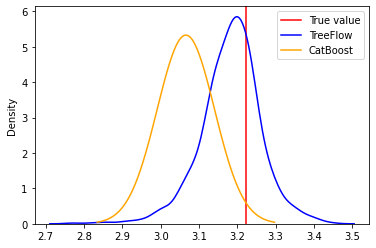

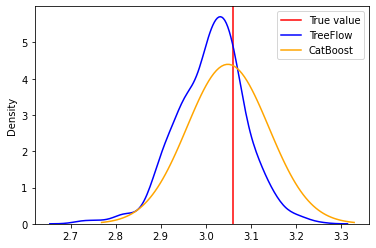

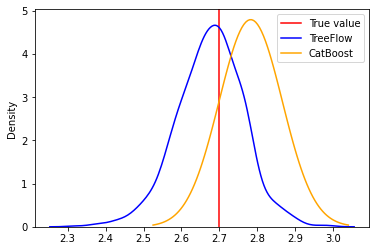

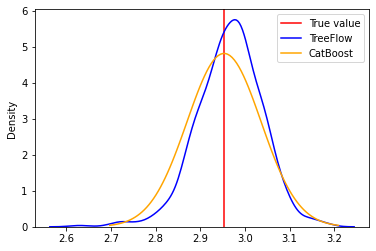

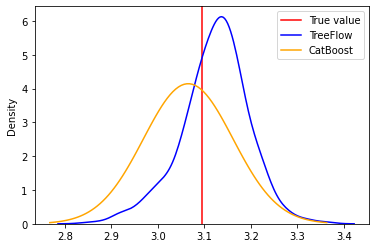

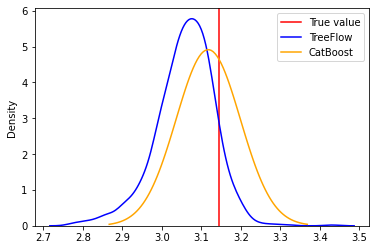

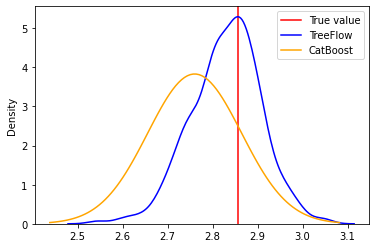

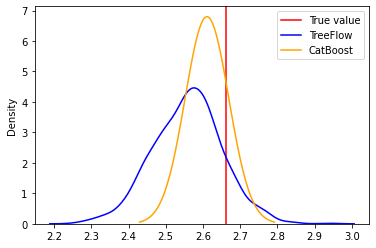

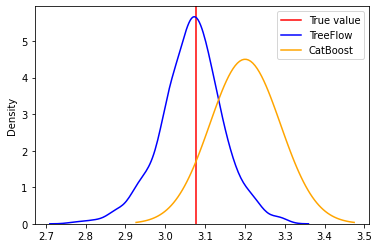

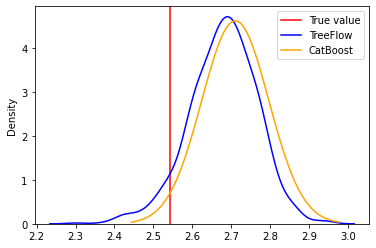

In [19]:
for i in range(10):
    plt.axvline(x=y_test.values[i, :], color='r', label='True value')

    sns.kdeplot(y_test_samples[i, :], color='blue', label='TreeFlow')

    x = np.linspace(
        stats.norm.ppf(0.001, loc=y_test_catboost[i, 0], scale=np.sqrt(y_test_catboost[i, 1])), 
        stats.norm.ppf(0.999, loc=y_test_catboost[i, 0], scale=np.sqrt(y_test_catboost[i, 1])), 
        100
    )
    plt.plot(x, stats.norm.pdf(x, loc=y_test_catboost[i, 0], scale=np.sqrt(y_test_catboost[i, 1])), color = 'orange', label='CatBoost')

    plt.legend()
    plt.show()